# First Example

This is the code for example 1 in "Practical Performance Evaluation of Entity Resolution Algorithms: Lessons Learned at PatentsView.org"

In [1]:
%%bash

pip install git+https://github.com/OlivierBinette/groupbyrule.git

  Cloning https://github.com/OlivierBinette/groupbyrule.git to /tmp/pip-req-build-w2ajlu5n
  Resolved https://github.com/OlivierBinette/groupbyrule.git to commit df3032320395ea1c2513019c2b8cf8b3a2d2f2d9


  Running command git clone -q https://github.com/OlivierBinette/groupbyrule.git /tmp/pip-req-build-w2ajlu5n
  Running command git submodule update --init --recursive -q


In [2]:
import numpy as np
import pandas as pd
from groupbyrule.data import load_RLdata10000
from groupbyrule import Any, Match

/home/ubuntu/miniconda3/envs/pv-evaluation/lib/python3.7/site-packages/groupbyrule/comparator/__init__.py:11: UserWarning: Could not load C++ shared library. Using pure Python implementation instead.
  "Could not load C++ shared library. Using pure Python implementation instead.")


We use RLdata10000 throughout.

In [3]:
df = load_RLdata10000()

The disambiguation algorithm which we consider matches two records if they match on all of first name, last name and birth year, if they match on first name, birth day and birth year, OR if they match on last name, birth day and birth year.

In [4]:
rule = Any(
    Match("fname_c1", "lname_c1", "by"),
    Match("fname_c1", "bd", "by"),
    Match("lname_c1", "bd", "by")
)

# Apply the rule to a dataset
rule.fit(df)

disambiguation = pd.Series(rule.groups, df.index)

This is not a good algorithm. It only achieves 52% precision and 83% recall.

In [5]:
from pv_evaluation.metrics import pairwise_precision, pairwise_precision_recall

pairwise_precision_recall(disambiguation, df.identity)

(0.520625, 0.833)

In [6]:
true_precision = pairwise_precision(disambiguation, df.identity)

Now we sample 100 clusters and use this as a benchmark dataset to compute precision. That is, precision is computed for predictions contained in the benchmark dataset. The process is repeated 2000 time in order to estimate the distribution of this estimator.

In [7]:
def sample_clusters(df, k=200):
    clusters = np.random.choice(df.identity.values, size=k, replace=True)
    return df[df.identity.isin(clusters)]

n = 5000
precision_values = np.zeros(n)
for i in range(n):
    benchmark = sample_clusters(df)
    data = pd.concat({"prediction":disambiguation, "reference":benchmark.identity}, axis=1, join="inner")
    precision_values[i] = (
        pairwise_precision(data.prediction, data.reference)
    )

As we can see below, this "trivial" estimator is highly biased. Most of the time, we observe 100% accuracy, despite the fact that true accuracy is only 52%.

<AxesSubplot:ylabel='Count'>

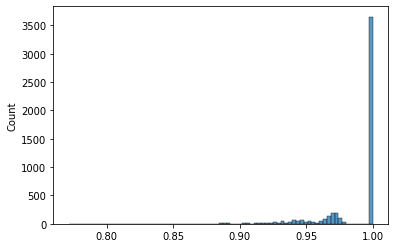

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(precision_values)

Next, do the same experiment again but using our proposed precision estimator which accounts for the sampling structure.

In [ ]:
import pandas as pd
from pv_evaluation.estimators import pairwise_precision_estimator

n = 5000
est_precision_values = np.zeros(n)
for i in range(n):
    benchmark = sample_clusters(df)
    est_precision_values[i] = (
        pairwise_precision_estimator(disambiguation, benchmark.identity, sampling_type="cluster", weights="cluster_size")
    )

Our estimator is nearly unbiased.

In [ ]:
np.mean(est_precision_values)

0.8591505519137856

<AxesSubplot:ylabel='Count'>

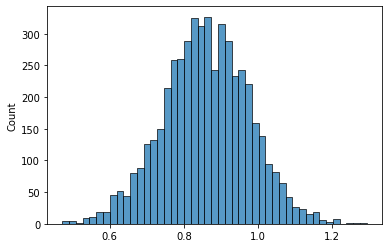

In [ ]:
sns.histplot(est_precision_values)

Finally, we can consider using the "single block" estimator which assumes that a single block has been sampled. This does not correspond exactly to the sampling mechanism used here. However, the results below show that it still provides precision estimates which are much more reasonable than what would be obtained using a trivial computation of precision.

In [ ]:
import pandas as pd
from pv_evaluation.estimators import pairwise_precision_estimator

n = 5000
block_est_precision_values = np.zeros(n)
for i in range(n):
    benchmark = sample_clusters(df)
    block_est_precision_values[i] = (
        pairwise_precision_estimator(disambiguation, benchmark.identity, sampling_type="single_block", weights="uniform")
    )

In [ ]:
np.mean(block_est_precision_values)

0.5912823035527661

<AxesSubplot:ylabel='Count'>

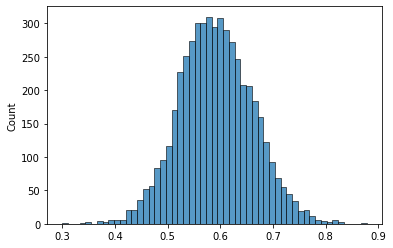

In [ ]:
sns.histplot(block_est_precision_values)

## Paper figure

The figure appearing in the paper is constructed below.

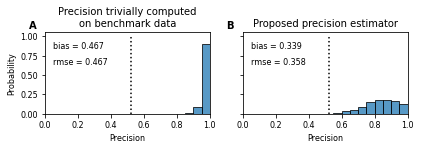

In [ ]:
plt.rc('font', size=8) #controls default text size
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 

fig, (ax1, ax2) = plt.subplots(figsize=(6.5, 1.5), ncols=2, sharey=True)

sns.histplot(precision_values, stat="probability", binwidth=0.05, binrange=(0,1), ax=ax1)
ax1.set_xlim(0,1)
ax1.set_xlabel("Precision")
ax1.vlines(x=pairwise_precision(disambiguation, df.identity), ymin=0, ymax=1, colors="black", linestyles="dotted",)
ax1.set_title("Precision trivially computed\non benchmark data")
ax1.text(-0.1, 1.05, "A", transform=ax1.transAxes, size=10, weight='bold')

ax1.text(0.05, 0.8, f"bias = {round(np.mean(precision_values) - true_precision, 3)}", transform=ax1.transAxes, size=8, weight='normal')
ax1.text(0.05, 0.6, f"rmse = {round(np.sqrt(np.mean((precision_values - true_precision)**2)), 3)}", transform=ax1.transAxes, size=8, weight='normal')


sns.histplot(est_precision_values, stat="probability", binwidth=0.05, binrange=(0,1), ax=ax2)
ax2.set_xlim(0,1)
ax2.set_xlabel("Precision")
ax2.vlines(x=pairwise_precision(disambiguation, df.identity), ymin=0, ymax=1, colors="black", linestyles="dotted")
ax2.set_title("Proposed precision estimator")
ax2.text(-0.1, 1.05, "B", transform=ax2.transAxes, size=10, weight='bold')

ax2.text(0.05, 0.8, f"bias = {round(np.mean(est_precision_values) - true_precision, 3)}", transform=ax2.transAxes, size=8, weight='normal')
ax2.text(0.05, 0.6, f"rmse = {round(np.sqrt(np.mean((est_precision_values - true_precision)**2)), 3)}", transform=ax2.transAxes, size=8, weight='normal')


plt.savefig("first-example.pdf", format="pdf", bbox_inches="tight")
plt.show()